In [1]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#other libraries
from tqdm import tqdm
import time
import random
import os
import sys
from pathlib import Path
import h5py

#torch specific
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor

#Using newest versions of all libraries

In [2]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *
from imcal import CalorimeterDataset
from imcal import RandomRoll

In [3]:
#variables controlled by the user. Change these to fit your specific needs.
VAL_PCT = 0.7 #The percentage of the data to be used as the validation set.
N_EVENTS = 10000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.

#N_LABELS = [0, 1, 2] #A list containing the classes of n number of jets we wish to train for
#LABELS = ["black_holes", "ttbar", "sphalerons"]
#FILENAMES = ["black_holes_9996_events_n.h5", "ttbar_13TeV_pTmin1000_10000_events_n.h5", "sphalerons_10000_events_n.h5"]

#LABELS = ["BH_n2_M12", "BH_n5_M8", "SPH_9"]
LABELS = ["BH_n5_M10TeV", "SPH_9"]
#N_LABELS = [0, 1] #integer labels for the model
#FILENAMES = ["BH_n2_M12_10000_events.h5", "BH_n5_M8_10000_events.h5", "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_10000_events.h5"]
FILENAMES = ["BH_n5_M10_res100_10000_events.h5", "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res100_10000_events.h5"]
#filters = ["saturate", "normalise"]
filters=["saturate"]

CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
DATAPATH = Path("/disk/atlas3/data_MC/2dhistograms/") #The path to the folder containing the histogram files
RES = 100 #resolution

MODEL_NAME = f'resnet_{str(int(time.time()))}' #A unique name for the model
print(MODEL_NAME)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


resnet_1667484952
Running on the GPU


In [4]:
def load_hd5_histogram(path:Path, n_events:int):
    with h5py.File(path) as f:
        print (f.keys())
        data = f["images"][0:N_EVENTS]
        #create array
        arr = np.array(data)
        print(f"Loaded data with {len(arr)} entries of shape {np.shape(arr)}")
        print(f"Check max value: {np.max(arr)}")
        #Filters (normalise etc)
        #arr = apply_filters(filters, arr, maxvalue=2000)
        return Tensor(arr)

def label_maker(n_classes:int, n_events:int):
    #Creates labels for the classes. The first class gets value [1, 0, .., 0], the next [0, 1, ..., 0] etc
    a = torch.zeros(n_events*n_classes, n_classes, dtype=torch.int)
    for i in range(n_classes):
        for j in range(n_events):
            a[n_events*i + j][i] = 1
    return a

class RandomRoll(torch.nn.Module):
    """
    Applies a random roll to the image along a given axis.
    """
    def __init__(self, roll_axis):
        """
        Args:
            roll_axis (int): Axis to roll along. 0 -> y axis rolling, 1-> x-axis rolling
        """
        super().__init__()
        assert isinstance(roll_axis, int)
        self.roll_axis = roll_axis
        if roll_axis > 2:
            print("You should seriously reconsider this.")

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be rolled.

        Returns:
            PIL Image or Tensor: Randomly rolled image.
        """
        roll_axis = self.roll_axis
        shift = torch.randint(low=0, high=list(img.shape)[roll_axis], size=(1,1)).item()
        img = torch.roll(img, shift, roll_axis)
        return img


def load_datasets(input_files, data_path, n_events, val_pct=0.1):
    #Loads the data files
    val_size = int(n_events*val_pct)
    train_size = int(n_events*(1-val_pct))
    data = [load_hd5_histogram(data_path / file, n_events) for file in input_files]
    #Partitions off training data
    Cal_train = torch.cat([item[0:train_size] for item in data]).float().to(device)
    labels_train = label_maker(len(data), train_size).float().to(device)
    #Testing data
    Cal_test = torch.cat([item[(train_size):(train_size+val_size)] for item in data]).float().to(device)
    labels_test = label_maker(len(data), val_size).float().to(device)
    #Check everything is ok
    print(f"Data has shape {Cal_test[0].shape}. {len(labels_train)} training images and {len(labels_test)} testing images")
    print(f"There are {len(data)} classes.")
    
    transforms = torch.nn.Sequential(
        torchv.transforms.RandomVerticalFlip(),
        #torchv.transforms.RandomHorizontalFlip(),
        RandomRoll(0)
    )

    train_dataset = CalorimeterDataset(Cal_train, labels_train, transform=transforms)
    #train_dataset = CalorimeterDataset(Cal_train, labels_train)
    test_dataset = CalorimeterDataset(Cal_test, labels_test)
    
    return train_dataset, test_dataset

In [5]:
#load data
traindata, testdata = load_datasets(FILENAMES, DATAPATH, N_EVENTS, VAL_PCT)
print(torch.cuda.memory_summary(device=None, abbreviated=False))

<KeysViewHDF5 ['Events', 'Input', 'Resolution', 'images']>
Loaded data with 10000 entries of shape (10000, 100, 100, 3)
Check max value: 21898.841796875
<KeysViewHDF5 ['Events', 'Input', 'Resolution', 'images']>
Loaded data with 10000 entries of shape (10000, 100, 100, 3)
Check max value: 13608.056640625
Data has shape torch.Size([100, 100, 3]). 6000 training images and 14000 testing images
There are 2 classes.
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    2288 MB | 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0, 0, 0, 0], [1, 1, 1, 1]]
[[6, 39, 87, 88], [3031, 3075, 3086, 3021]]
Image shape:  torch.Size([100, 100, 3])


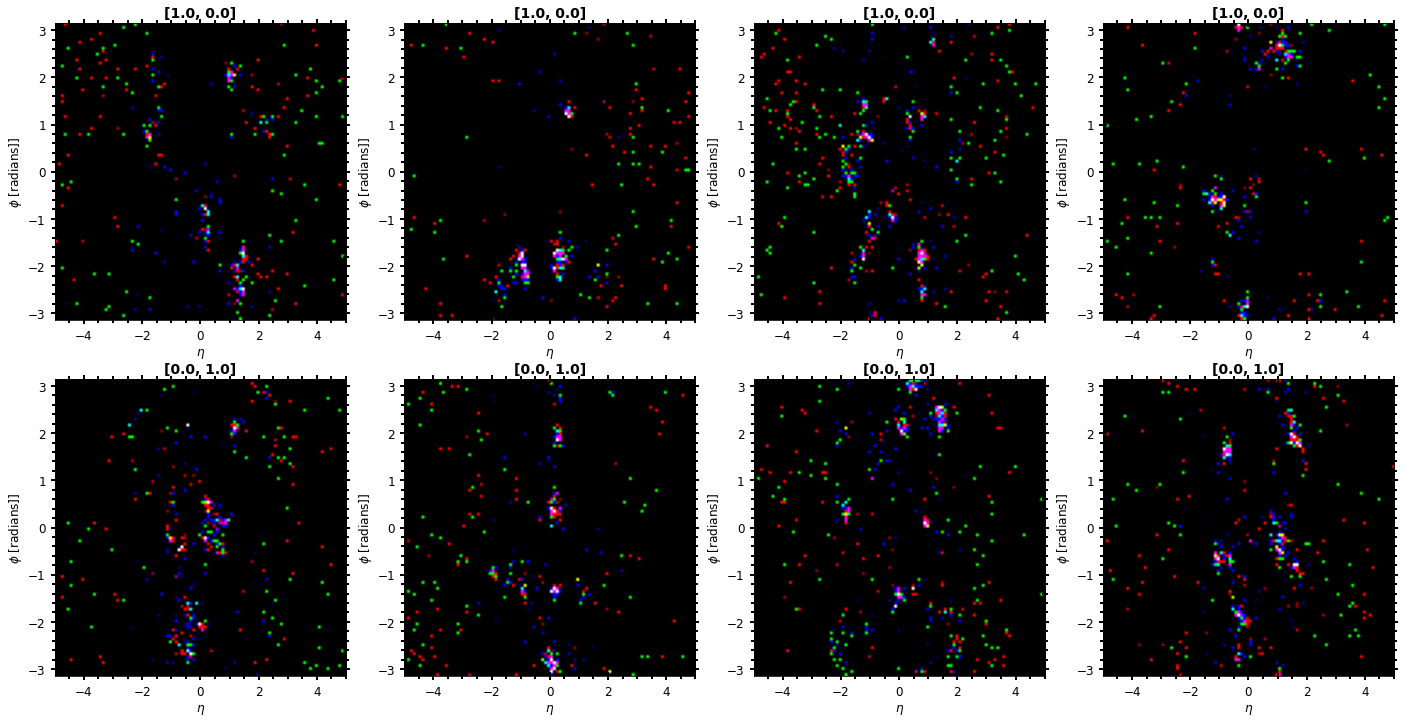

In [6]:
view_data(traindata, 4, CLASSES, N_EVENTS*(1-VAL_PCT))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for a random image
[ 280.76666  298.61423  424.20016  439.71326  759.70746  762.89966
  966.09064 1091.7258  1242.5676 ]
Looking at image 3468


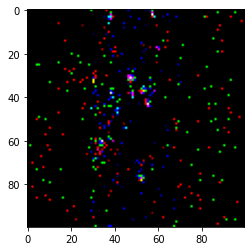

In [7]:
k = np.random.randint(0, len(traindata.images))
image = traindata.images[k].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


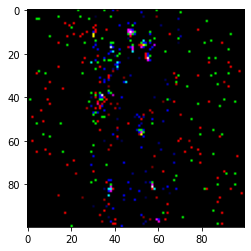

In [8]:
rolled_image = RandomRoll(0)(image)
#rolled_image = torchv.transforms.RandomVerticalFlip()(rolled_image)
plt.imshow(rolled_image)

### Create net and train

In [9]:
#create NN and test that nothing major is wrong.
from resnet import ResNet18
resnet = ResNet18(img_channels=3, num_classes=CLASSES)
resnet.to(device = device)

testimage, testlabel = traindata.images[0], traindata.img_labels[0]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(device)))

torch.Size([1, 3, 100, 100])
tensor([[0.0101, 0.3599]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [10]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
training_results = train(resnet, traindata, testdata, 2**7, 20, RES, device, optimizer)

100%|██████████| 20/20 [01:04<00:00,  3.23s/it]


In [11]:
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(device)))

torch.Size([1, 3, 100, 100])
tensor([[ 0.5477, -0.4203]], device='cuda:0', grad_fn=<AddmmBackward0>)


<AxesSubplot:xlabel='Iteration'>

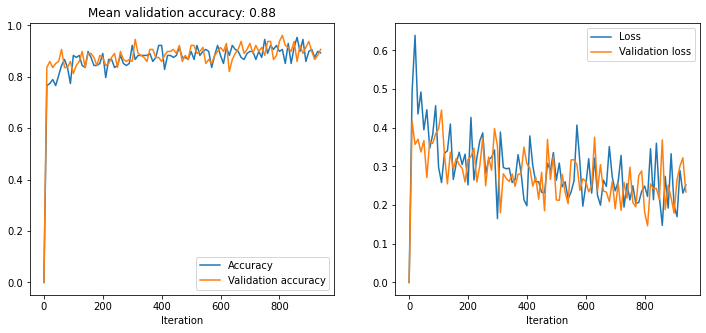

In [12]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])
#axs[0].set_ylim(0.6, 1)

In [13]:
from sklearn.metrics import accuracy_score
truth, preds = predict(resnet, testdata, 100, RES, device)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 140/140 [00:01<00:00, 94.72it/s]

14000


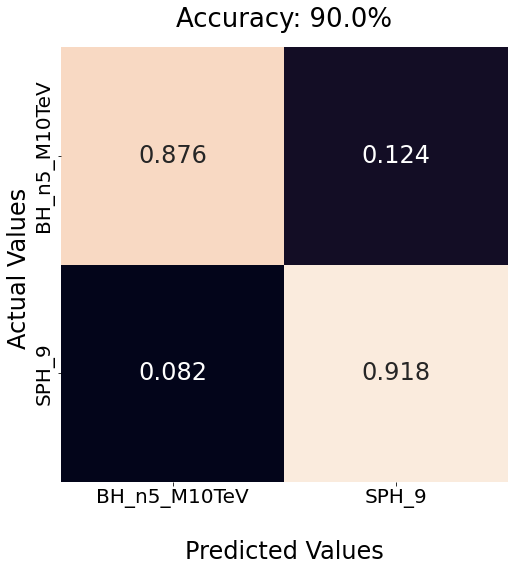

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

fig, ax = plt.subplots(figsize = (8, 8))

#Generate the confusion matrix
cf_matrix = confusion_matrix(confusion["Truth"], confusion["Predictions"], normalize="true")
cf_matrix = np.round(cf_matrix, 3)
ax = sn.heatmap(cf_matrix, annot=True, cbar=False, cmap='rocket', fmt='g',annot_kws={"size": 24})

#ax.set_title('Confusion matrix\n\n', size=24)
ax.set_xlabel('\nPredicted Values', size=24)
ax.set_ylabel('Actual Values ', size=24)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(LABELS, size=20)
ax.yaxis.set_ticklabels(LABELS, size=20)
ax.set_title(f"Accuracy: {round(accuracy, 2)*100}%", size=26, pad=20)

## Display the visualization of the Confusion Matrix.
plt.show()